In [2]:
# Install necessary packages
!pip install gymnasium torch numpy matplotlib ambiance aerodynamics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 19.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/rl/new_RLproject2

/content/gdrive/MyDrive/rl/new_RLproject2


In [4]:
!ls

 coordinate_of_the_system.jpg   rocket.py		       train.ipynb
 new_RLproject2		       'single_stage_rocket copy.py'   two_stage_rocket.py
 policy2.py		        single_stage_rocket.py	       two_stage_rocket_w_aerodynamics.py
 policy.py		        test_rocket.py		       Untitled0.ipynb
 ppo_rocket.zip		        test_train.py		       utils.py
 __pycache__		        train_data
 README.md		        train_data2


In [5]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ambiance import Atmosphere
import gymnasium as gym
from gymnasium import spaces
from rocket import Rocket  # Import Rocket class from rocket.py

In [6]:
from torch.distributions import Normal

In [7]:
Path = '/content/gdrive/MyDrive/rl/new_RLproject2/train_data/'

In [8]:
import pickle

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import os
import pickle
import csv
from collections import deque
import pandas as pd

class PPORocketAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPORocketAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.log_std = nn.Parameter(torch.ones(action_dim) * 0.5)

    def forward(self, state):
        return self.actor(state), self.critic(state)

    def get_action(self, state):
        action_mean, _ = self.forward(state)
        action_log_std = self.log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)
        normal = Normal(action_mean, action_std)
        action = normal.sample()
        action_log_prob = normal.log_prob(action).sum(dim=-1)
        return action, action_log_prob

def scale_action(action, low, high):
    # Ensure action is within [-1, 1]
    action = np.clip(action, -1, 1)
    scaled_action = low + (0.5 * (action + 1.0) * (high - low))
    return scaled_action

def normalize_state(state):
    return (state - state.mean()) / (state.std() + 1e-8)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def train_ppo_agent(env, agent, num_episodes=1000, learning_rate=1e-3, gamma=0.90, clip_epsilon=0.2, update_timestep=200, k_epochs=4, save_path='/content/gdrive/MyDrive/', early_stopping_threshold=30000):
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()
    episode_rewards = []
    action_records = []  # 액션 기록을 저장할 리스트
    losses = []

    action_low = np.array([-10] * 10 + [0.4 * env.max_thrust[0]] * 5 + [-10] * 6 + [0.4 * env.max_thrust[1]] * 3)
    action_high = np.array([10] * 10 + [env.max_thrust[0]] * 5 + [10] * 6 + [env.max_thrust[1]] * 3)

    # 모델 경로와 보상 경로 설정
    model_path = os.path.join(save_path, 'ppo_rocket_model.pth')
    rewards_path = os.path.join(save_path, 'episode_rewards.pkl')
    actions_path = os.path.join(save_path, 'action_records.csv')  # 액션 기록 경로
    loss_path = os.path.join(save_path, 'loss_records.pkl')

    # 모델 불러오기
    if os.path.exists(model_path):
        agent.load_state_dict(torch.load(model_path))
        print("Model loaded successfully!")

    # 에피소드 보상 불러오기
    if os.path.exists(rewards_path):
        with open(rewards_path, 'rb') as f:
            episode_rewards = pickle.load(f)
        print("Episode rewards loaded successfully!")

    # 액션 저장 불러오기
    if os.path.exists(actions_path):
      with open(actions_path) as f:
        data=[tuple(line) for line in csv.reader(f)]
      print("Action list loaded successfully!")

    # loss 불러오기
    if os.path.exists(loss_path):
        with open(loss_path, 'rb') as f:
            losses = pickle.load(f)
        print("Losses loaded successfully!")

    timestep = 0
    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        episode_reward = 0
        episode_data = []
        epi_timestep = 0

        for t in range(env.max_step):
            timestep += 1
            epi_timestep += 1
            state = normalize_state(state)
            action, action_log_prob = agent.get_action(state)
            scaled_action = scale_action(action.detach().cpu().numpy()[0], action_low, action_high)
            action_records.append((episode,epi_timestep,scaled_action))
            next_state, reward, done, _ = env.step(scaled_action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            episode_reward += reward
            advantage = reward + gamma * agent(next_state)[1].item() - agent(state)[1].item()
            print(f'{epi_timestep} advantage : ', advantage)
            advantage = torch.tensor(advantage).view(-1, 1).detach().to(device)

            episode_data.append((state, action, action_log_prob, advantage, reward, next_state))

            if timestep % update_timestep == 0 or done:
                for _ in range(k_epochs):
                    for state, action, action_log_prob, advantage, reward, next_state in episode_data:
                        state = normalize_state(state)
                        action_mean, state_value = agent(state)
                        action_log_std = agent.log_std.expand_as(action_mean)
                        action_std = torch.exp(action_log_std)
                        normal = Normal(action_mean, action_std)
                        log_prob = normal.log_prob(action).sum(dim=-1)
                        ratio = torch.exp(log_prob - action_log_prob.detach())
                        surr1 = ratio * advantage
                        surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage
                        actor_loss = -torch.min(surr1, surr2).mean()
                        critic_loss = mse_loss(state_value, torch.tensor([reward + gamma * agent(next_state)[1].item()]).view(-1, 1).float().to(device).detach())
                        loss = 0.5 * critic_loss + actor_loss
                        losses.append(loss)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                episode_data = []

            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)

        # 평균 보상 계산 및 출력
        if len(episode_rewards)%100 >= 0:
            average_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward (last 100 episodes): {average_reward}")
            print()
            # 종료 조건
            if average_reward >= early_stopping_threshold:
                print(f"Early stopping at episode {episode} with average reward {average_reward}")
                break

        # 100개 에피소드마다 리워드 값을 plot으로 업데이트
        if (episode + 1) % 100 == 0:
            plt.figure(figsize=(10, 5))
            plt.plot(losses[-100:])  # 최근 100개의 loss를 plot
            plt.xlabel('updates')
            plt.ylabel('losses')
            plt.title('loss of last 100 updates')
            plt.show()

        if episode % 100 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}")
            env.show_path_from_state_buffer()
            # Save the model
            torch.save(agent.state_dict(), model_path)
            print(f"Model saved at {model_path}")
            # Save the episode rewards
            with open(rewards_path, 'wb') as f:
                pickle.dump(episode_rewards, f)
            print(f"Episode rewards saved at {rewards_path}")
            # Save the loss
            with open(loss_path, 'wb') as f:
                pickle.dump(losses, f)
            print(f"Loss saved at {loss_path}")

    # 액션 기록을 CSV 파일로 저장
    actions_df = pd.DataFrame(action_records, columns=['Episode', 'Timestep', 'Action'])
    actions_df.to_csv(actions_path, index=False)
    print(f"Action records saved at {actions_path}")

    # Final save
    torch.save(agent.state_dict(), model_path)
    print(f"Final model saved at {model_path}")
    # Save the episode rewards
    with open(rewards_path, 'wb') as f:
        pickle.dump(episode_rewards, f)
    print(f"Final episode rewards saved at {rewards_path}")

    return episode_rewards

학습률 1e-3 <- 3e-4

초기 표준편차 높게 설정:

self.log_std = nn.Parameter(torch.zeros(action_dim))


=>


self.log_std = nn.Parameter(torch.ones(action_dim) *0.5)


In [12]:
env = Rocket()  # Rocket 환경 인스턴스
state_dim = env.state_dims
action_dim = env.action_dims
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = PPORocketAgent(state_dim, action_dim).to(device)

# Train the agent
episode_rewards = []
episode_rewards = train_ppo_agent(env, agent, num_episodes=10000, save_path = Path, early_stopping_threshold=30000)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [19]:
  # 에피소드 보상 불러오기
rewards_path = os.path.join(Path, 'episode_rewards.pkl')
if os.path.exists(rewards_path):
    with open(rewards_path, 'rb') as f:
      episode_rewards = pickle.load(f)
    print("Episode rewards loaded successfully!")

Episode rewards loaded successfully!


In [28]:
episode_rewards=[]

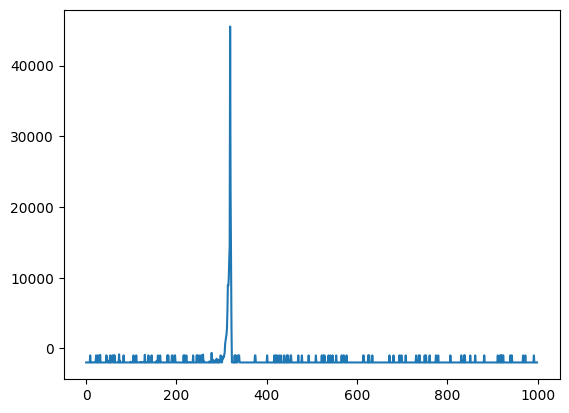

In [21]:
plt.plot(episode_rewards[6000:7000])

원인?: 갑자기 큰 reward를 받게 되는 환경으로 큰 reward가 정책에 큰영향을 주어 정책이 붕괴되는 것으로 추정.

In [29]:
%load_ext autoreload
%autoreload 2

In [31]:
%reload_ext autoreload

from rocket import Rocket  # Import Rocket class from rocket.py